# Boe Supervision Challenge Report
How do we prioritize which insurance firms to supervise? 

In [433]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display,Image
#from IPython.display import Image
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## Data Ingestion and Transformation

Joined, transformed, and save the datasset into a CSV that is ready for data analysis.

In [434]:
# convert excel sheets into dataframe
general_df = pd.read_excel('1_bronze_dataset.xlsx', sheet_name=0)
underwritting_df = pd.read_excel('1_bronze_dataset.xlsx', sheet_name=1)

# Combine the Year End and Metric columns
general_df.columns = general_df.columns + '_' + general_df.iloc[0]
general_df = general_df.drop([0])

underwritting_df.columns = underwritting_df.columns + '_' + underwritting_df.iloc[0]
underwritting_df = underwritting_df.drop([0])

# Rename first column to "Firm Name"
general_df.columns.values[0] = 'Firm Name'
underwritting_df.columns.values[0] = 'Firm Name'

# Merge the two dataframes
df = general_df.merge(underwritting_df, left_on='Firm Name', right_on='Firm Name', how='outer')

# Melt the dataframe
df = pd.melt(df, id_vars=['Firm Name'], var_name='Metric', value_name='Value')

# Remove unwanted characters from each Metric
df['Metric'] = df['Metric'].str.replace('.1', '')
df['Metric'] = df['Metric'].str.replace('.2', '')
df['Metric'] = df['Metric'].str.replace('.3', '')
df['Metric'] = df['Metric'].str.replace('.4', '')

# Split Year End values from each Metric into seperate columns
df[['Metric', 'Year End']] = df['Metric'].str.split('_', expand=True)

# Remove "YE" from Year End values
df['Year End'] = df['Year End'].str.replace('YE', '')

# Unmelt dataframe
df = pd.pivot_table(df, values = 'Value', index=['Firm Name','Year End'], columns = 'Metric').reset_index()

# Remove index column name
df = df.rename_axis(None, axis=1)

# Save dataframe as new CSV
df.to_csv('2_silver_dataset.csv', encoding='utf-8', index=False)
display(df.head())


,Firm Name,Year End,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
0,Firm 1,2016,2416.559785,1243.924991,46.76803,0.0,0.0,0.0,0.0,-17754.100486,0.0,0.0,0.0,0.0,0.0,2021.321862,0.16252,63676.869102,40171.683156
1,Firm 1,2017,3.796177,4.398725,0.0,0.588994,0.005515,0.675051,77.251254,0.0,9.894597,71.298841,41.01306,17.534691,17.184308,0.0,55887003.057573,9.566096,0.0
2,Firm 1,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Firm 1,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Firm 1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Results of Data Ingestion and Transformation

What has changed?

- I joined both datasets (General and Underwritting)
- Instead of each Metric having a seperate column for each "Year End" Value, I have created a "Year End" column, so that all each Metric is represented by only one column.

This dataset structure makes visualisation and analysis much simpler.

In [435]:
display(df.head())

,Firm Name,Year End,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
0,Firm 1,2016,2416.559785,1243.924991,46.76803,0.0,0.0,0.0,0.0,-17754.100486,0.0,0.0,0.0,0.0,0.0,2021.321862,0.16252,63676.869102,40171.683156
1,Firm 1,2017,3.796177,4.398725,0.0,0.588994,0.005515,0.675051,77.251254,0.0,9.894597,71.298841,41.01306,17.534691,17.184308,0.0,55887003.057573,9.566096,0.0
2,Firm 1,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Firm 1,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Firm 1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning

The dataset was already pretty clean. To further enhance its quality, I replaced any occurrences of 0s with NaNs and eliminatied outliers.

#### Replacing 0s with NaNs

There were a lot of 0s reported by insurance firms for each metric. By observing the context of the Metrics, it was unlikely that the actual values were 0 and more likely that there were no values reported. For this reason, I chose to replace all values in the dataset that was 0 to NaN instead.

In [436]:
# Load the transformed dataset
df = pd.read_csv('2_silver_dataset.csv')

# Replace all zeros with NaN given that is unlikely a zero is the real value of those metrics
df.replace(0, np.nan, inplace=True)


#### Removing Outliers

In [437]:
# Configure data type to String so that it is not mistaken for a numeric column
df['Firm Name'] = df['Firm Name'].astype(str)
df['Year End'] = df['Year End'].astype(str)

# List numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

Before analysing the data, it is important to check for outliers that might skew the results. I checked for outliers using visual means and by also observing the summary statistics of each Metric.

In [438]:
# Describe data
display(df.describe())

# Box plot of each column (commented out to reduce report size)
# for column in numeric_cols:   
#     sns.boxplot(data=df, x='Year End', y=column)
#     plt.show()

,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
count,1360.000000,1365.000000,1110.000000,1449.000000,1417.000000,1.267000e+03,1265.000000,1073.000000,1435.000000,1.235000e+03,1.234000e+03,1253.000000,1221.000000,1.359000e+03,1.358000e+03,1364.000000,1355.000000
mean,602.320736,641.794281,1371.287668,448.628978,206.574955,3.139600e+03,445.571393,1108.204771,288.159815,-4.437976e+03,-1.461708e+03,769.253769,652.046551,4.144828e+02,1.470283e+06,8631.151973,8491.140310
std,2461.050616,2358.409069,5704.712983,1234.497871,532.333959,1.117672e+05,16178.686443,4842.220929,784.396169,1.556336e+05,1.492040e+05,27836.806128,23739.560243,1.708682e+03,3.700454e+07,36362.182210,36555.223494
min,-162.245016,-123.609578,-19.777480,-167.815824,-189.936333,-1.406448e+04,-16112.406623,-17754.100486,-182.381851,-5.468706e+06,-4.495420e+06,-24817.785823,-33721.020240,1.867646e-09,-3.488211e+00,-207.356238,-1487.107764
25%,10.250982,11.112292,7.070893,7.065466,2.191648,3.521795e-01,0.139755,3.902015,3.023404,3.927756e-01,1.515120e-01,0.198470,0.171981,3.908801e+00,9.203866e-01,27.223696,11.765754
50%,47.544842,48.425189,58.437224,68.630510,32.608981,8.649898e-01,0.302267,35.960668,37.358641,9.142253e-01,3.672417e-01,0.521793,0.481683,2.311497e+01,1.988065e+00,167.078648,95.952245
75%,233.210803,230.108922,424.251489,336.425819,169.773552,1.436066e+00,0.515924,302.760593,217.798775,1.505411e+00,6.287726e-01,0.944852,0.883788,1.278356e+02,3.485000e+00,1336.916774,997.358345
max,41636.299252,26705.042053,74078.635849,19292.066525,6844.014131,3.978266e+06,575064.786983,75526.673293,11351.609021,4.318219e+04,2.691212e+06,985011.303759,828809.371523,2.278836e+04,9.993029e+08,553549.903858,494498.525611


From the data presented, I observed that several columns exhibited obvious outliers:

- Gross Combination Ratio
- Gross Expense Ratio
- Net Combination Ratio
- Net Expense Ratio
- Pure Gross Claims Ratio
- Pure Net Claims Ratio
- SCR Coverage Ratio

Additionally, I observed that the data distribution for all these columns appeared to be skewed, predominantly to the right. There is reason to believe that this skewness is typical in the insurance industry, where a few large players coexist with numerous smaller ones.

Given the skewed distribution, I chose to employ the interquartile range to detect and remove outliers.

Recognizing the challenge of distinguishing outliers and the need to identify large and high-risk firms for supervision, I adopted a conservative approach and set relatively high upper limit.


The steps I took to remove outliers:

1. Adding a condition to remove rows that had data that did not fall within the first limits (Q1 - 3 * IQR and Q3 + 10 * IQR)

In [439]:
# Calculate quantiles and IQR
Q1 = df[numeric_cols].quantile(0.25) 
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Setting upper and lower limit
upper_limit = Q3 + 10 * IQR
lower_limit = Q1 - 3 * IQR

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((df[numeric_cols] < (lower_limit)) | (df[numeric_cols] > (upper_limit))).any(axis=1)

# Create a dataframe of rows which fall outside limits
df_outside_limit = df[~condition]



2. Updating the condition to re-add the rows if the more than 2 rows of the same firm was removed. (Reasoning: The firm could be massive and have metrics that fall outside the limits for multiple years)

In [440]:

# Update conditions for firms which have have more than two or more rows outside limit:
for i, firm_names in df_outside_limit['Firm Name'].items():
    if len(df_outside_limit[df_outside_limit['Firm Name'] == firm_names]) > 1:
        condition[i]=True


3. Updating the condition again to remove rows which fall drastically outside a very high upper limit (Q3 + 50 * IQR). (Reasoning: After re-adding firms that had more than two rows that fell outside the limit, I still found some extreme outliers. By removing all rows above the increased upper limit, these extreme outliers could be removed.)

In [441]:

# Update conditions for rows which stil exhibit extreme outliers
# New upper limit
new_upper_limit = Q3 + 50 * IQR
new_lower_limit = Q1 - 3 * IQR

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((df[numeric_cols] < (new_lower_limit)) | (df[numeric_cols] > (new_upper_limit))).any(axis=1)

# Filter our dataframe based on condition
df_no_outlier = df[condition]

# Save cleaned dataset to csv file
df_no_outlier.to_csv('3_gold_dataset.csv', encoding='utf-8', index=False)

#### Results of Data Cleaning
After removing the outliers and saving the new dataset in a new csv file, I created a few graphs of the refined dataset in the Tableau Dashboard provided below. You can explore the updated distribution of each metric by choosing the specific metric from the dropdown menu. The obvious outliers have been effectively removed, creating a clearer representation of the data.

In [442]:

%%HTML
<div class='tableauPlaceholder' id='viz1701026923696' style='position: relative'><noscript><a href='#'><img alt='BoE Supervision Challenge ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-NewDistribution&#47;DistributionDashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BoESupervisionChallenge-NewDistribution&#47;DistributionDashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-NewDistribution&#47;DistributionDashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1701026923696');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Data Exploration:

Before exploring the dataset, I spent time understanding the meaning of all the metrics provided. Although each metric offers unique insights into the performance of insurance firms, there are overlaps in how they indicate the size, riskiness, and profitability of a firm.

To provide the analysis with greater direction and focus, I gave special consideration to Gross Written Premiums (GWP), a key indicator of size, and the Solvency Capital Requirement (SCR) Coverage Ratio, a pivotal metric indicating risk.

In [443]:
%%HTML
<div class='tableauPlaceholder' id='viz1701028335372' style='position: relative'><noscript><a href='#'><img alt='Story 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-AnalysisReport&#47;Story1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BoESupervisionChallenge-AnalysisReport&#47;Story1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-AnalysisReport&#47;Story1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1701028335372');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1016px';vizElement.style.height='991px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>


##### Tableau Visuals Page 1

Initially, I hypothesized a landscape in the insurance sector with a few major players and numerous smaller ones. To investigate the size distribution, I used Gross Written Premiums (GWP) and found that the hypothesis was largely accurate, as revealed in the Tableau Visuals (page 1).

After that, I examined the correlation between firm size (measured by GWP) and each metric. As expected, there was a clear correlation with Total Assets, Total Liabilities, and Net Written Premiums (NWP).

However, there were no evident correlations between the size (GWP) and other metrics, such as those indicative of risk and profitability.

##### Tableau Visuals Page 2

Given the logical emphasis on larger and riskier firms, I aimed to visually assess the latest (Year 2020) distribution of companies concerning Size and Risk, which you will see in the Tableau Visuals (page 2)

In pursuit of this perspective, I grouped the data into four groups which you can differentiate through the different colours on the plot:

- Big and Risky (SCR < 1 and GWP > £500M)
- Big (SCR >=1 and GWP > £500M)
- Small and Risky (SCR < 1 and GWP < £500M)
- Neutral

You can also see the count of firms in each Group at the bottom of the dashboard, which help indicate how much resources we need to put in for each Group.

To determine which firms to supervise, I thought we could begin with a straightforward benchmark, prioritizing "Big and Risk," followed by "Small and Risky," and then "Big."

##### Tableau Visuals Page 3

Having established a benchmark, I further investigated the potential relationships between these Groups and other metrics. However, no distinct relationships were identified between these Groups and the remaining metrics.

##### Tableau Visuals Page 4

Now that we have highlighted categories, we can turn our attention to additional metrics and identify specific firms that warrant attention on our radar, as depicted in the last dashboard. On this page, we can highlight the dots that we want to pay special attention to and the firm names will show on the right. We can then focus on these firms for supervision.

### Data Clustering

I decide to use K-means clustering to find patterns in the dataset to see if we can identify natural groupings or clusters with similarities. In the context of insurance firms, this method would allow us to group firms which can provide valuable insights for determining which firms to supervise.

By applying K-means clustering to insurance firm data, I hoped to discover patterns or groupings related to size, riskiness, profitability, or other relevant factors.

#### K-means Clustering

In [444]:
# Load your dataset
df = pd.read_csv('3_gold_dataset.csv')

# filter by year
df = df[df['Year End'] == 2020]

# Select the relevant metrics for clustering
metrics = df.select_dtypes(include=[np.number]).columns

# Extract the selected metrics
data = df[metrics]

# Handle missing values
data.fillna(data.mean(), inplace=True) 

# Standardize the data (important for K-means)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Choose the number of clusters (you may need to experiment with this)
num_clusters = 4

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=3)
df['cluster'] = kmeans.fit_predict(scaled_data)

#### Results of K-means clustering

In [445]:
# Number of firms in each cluster
value_counts = df['cluster'].value_counts()
value_counts_df = pd.DataFrame({'Cluster': value_counts.index, 'Count': value_counts.values})

display(value_counts_df.style.hide(axis="index"))

Cluster,Count
3,392
2,19
0,11
1,1


In [446]:
# Compare metrics by cluster
display(df.groupby('cluster')[numeric_cols].mean())

,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
cluster,,,,,,,,,,,,,,,,,
0,871.641059,1165.805932,3263.128422,284.668669,290.159108,1.008872,0.295145,3656.001383,209.779979,0.787603,0.283517,0.613801,0.391092,891.120315,1.705647,17208.863737,18298.672132
1,10287.309499,8279.521225,365.441556,NaN,NaN,NaN,NaN,1396.297028,NaN,NaN,NaN,NaN,NaN,4143.092997,3.278201,16320.072011,2225.159382
2,208.326726,209.384957,321.875003,2450.765637,1342.565775,1.122665,0.361888,103.072847,2102.112770,1.036765,0.334615,0.658279,0.660011,108.824077,2.776726,765.391450,679.290253
3,128.913425,149.090729,206.383839,245.693634,99.815070,1.039689,0.394288,153.925601,150.299413,1.109548,0.517355,0.660022,0.579491,74.451959,3.766713,828.723684,708.692600


#### Observations of results

After experimenting with different cluster numbers, I found the results with 4 clusters the most meaningful.

Based on my K-means clustering findings, I've identified distinct characteristics for each cluster. Here's a summarized overview:

Cluster 0: Large Insurance Companies
- Characteristics: High values in Gross Written Premium (GWP), Total Assets, and Liabilities.
- Interpretation: Represents insurance companies that are considered large based on various financial indicators.

Cluster 1: Undetected Outlier Firm
- Characterisics: Many NaN Values 
- Interpretation: This firm was significantly different from the rest of the firms, leading the K-means algorithm to isolate it into its own cluster.

Cluster 2: High Liabilities despite Moderate Size
- Characteristics: High Gross Best Estimate Liability (BEL), Net BEL, and gross claims. However, the Gross Written Premium (GWP) suggests a moderate size.
- Interpretation: Suggests companies with significant liabilities relative to their size in terms of GWP, warranting attention due to the potential risk associated with large liabilities.

Cluster 3: Moderate Characteristics
- Characteristics: Does not stand out significantly compared to the other clusters.
- Interpretation: Represents a group that does not exhibit extreme values in the observed features.
Supervision Focus:

#### Comparing K-means Results with earlier Groupings

I found it intriguing to juxtapose the outcomes of the K-means clustering with the predefined groupings I established in Tableau based on specific criteria:

- Big and Risky: Entities with a Solvency Capital Requirement (SCR) below 1 and Gross Written Premium (GWP) exceeding £500 million.
- Big: Entities with an SCR equal to or greater than 1 and GWP surpassing £500 million.
- Small and Risky: Entities with an SCR below 1 and GWP less than £500 million.
- Neutral: Entities falling outside the criteria of the above groups.

To explore this comparison, I visualized the data on a chart plotting GWP against the SCR coverage ratio.

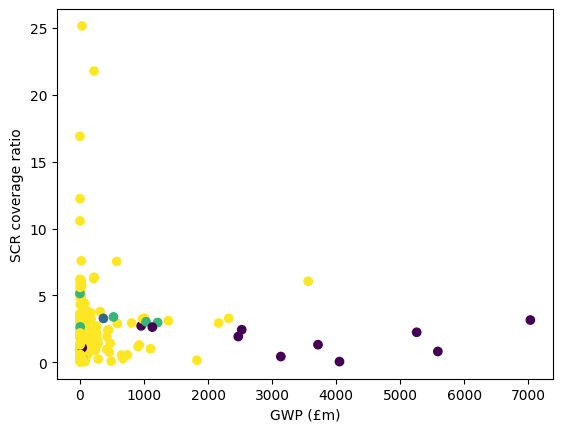

In [447]:
# Compare clustering findings with Tableau Groups that I created 
plt.scatter(df['GWP (£m)'], df['SCR coverage ratio'], c=df['cluster'])

plt.xlabel('GWP (£m)')
plt.ylabel('SCR coverage ratio')
plt.show()

### Findings from Comparison

Based on the chart, it appears that our classifications aligned effectively for the "Big" firms category. However, there is a degree of ambiguity in delineating the other categories.

## Azure Solution


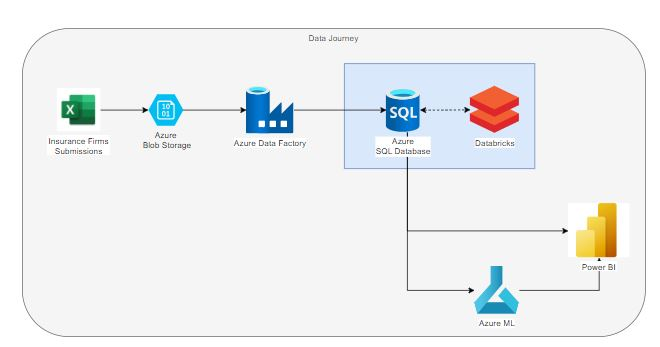

In [448]:
Image(filename="Azure Solution.JPG") 

#### Data Journey

In this simple Azure-based data journey, insurers can initiate the process by submitting forms, which can be deposited into Azure Blob Storage. The orchestration continues with Azure Data Factory ingesting these files on a daily scedule, preserving the raw form of the data in an Azure SQL database. Leveraging the capabilities of Azure Databricks, we can conduct further Extract, Transform, Load (ETL) processes to produce more meaningful tables from the raw data. This transformed relational database becomes a foundation ready for both machine learning on Azure ML, and visualization using Power BI. This sequence on Azure allows would allow for a simple end-to-end data journey on the Azure platform.

##### Considerations

- Azure Data Factory (ADF) was selected for Data Ingestion because it is user-friendly with a drag-and-drop interface, which is suitable for scenarios where frequent code modifications are not anticipated. Since the forms layout that insurers need to submit are unlikely to change often, using ADF is ideal.

- While Databricks requires higher technical ability compared to ADF, it was chosen as the data engineering layer because it offers more flexibility and supports various coding languages. It allows for more room to enhance data pipelines and adapt to foreseable frequent changes in business requirements. 

- Azure ML Studio would serve as the dedicated machine learning layer, providing a seperate environment for machine learning specialist within a team to manage machine learning jobs. 

- Azure SQL Database was chosen because it adopts the widely used SQL query language and allows for efficient relational database management. This database can also be easily scaled based on growing storage demand.

- Power Bi would provide an easy to use platform for data scientist to produce visuals that help with data analysis.

This simple intial set-up addresses usability, flexibility, and industry compatibility across data integration, ETL processes, machine learning, and database management within the technology stack.



#### Solution Deployment

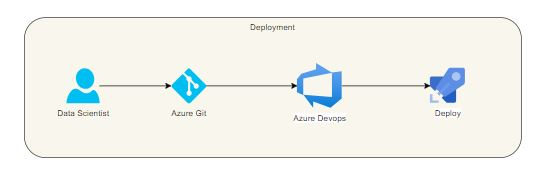

In [449]:
Image(filename="Azure Deployment.JPG") 

This deployment plan in Azure involves a process that begins with the Data Scientists making code changes and pushing them to a Git branch for version control. Azure DevOps is then used for Continuous Integration (CI) and Continuous Deployment (CD) management. 

During CI, the system automatically builds and tests the code with each push to the Git repository, integrating the solution seamlessly. The CD pipeline willl also automate deployment and reduce manual intervention. After successful CI/CD completion, the code changes will be deployed to it's target Azure Environment.




#### Upgrading with Azure

Once the project has matured, we can also upgrade this Azure solution through various means such as:
- Adding a web interface for the Insurance submitter to interact with and drop submissions.
- Implementing Azure VMs for consistent development environments, and efficiently manage multiple testing and development environments. 
- For some services such as Azure SQL database, we can also enable dynamic scaling to handle variable workloads effectively. 
- As data security is also our top priority, we can leverage the capabilities of Azure Active Directory, Azure Security Center and Azure Key Vault to cover critical security aspects.
- We can explore additional services like Azure Analysis Services to enhance analytical capabilities. 